In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
model = nn.Sequential(
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,10),
    nn.Sigmoid()
)

In [ ]:
model = nn.Sequential(
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,10),
    nn.Sigmoid()
)

In [ ]:
def create_velocity(model):
  velocity = []
  for m in model:
    if isinstance(m, nn.Linear):
      velocity.append(torch.rand_like(m.weight))
  return velocity

In [ ]:
def update_velocity(model,velocity,global_best,local_best,alpha=1,beta=1):
  new_velocity = []
  j=0
  for i in range(len(model)):
    if isinstance(model[i], nn.Linear):
      new_velocity.append(velocity[j]+alpha*(global_best[i].weight-model[i].weight)+beta*(global_best[i].weight-model[i].weight))
      j+=1
  return new_velocity

In [ ]:
def update_position(model,velocity):
  j=0
  for i in range(len(model)):
    if isinstance(model[i], nn.Linear):
      model[i].weight = nn.Parameter(model[i].weight+velocity[j])
      j+=1
  return model

In [ ]:
def create_particle(model):
  new_model = copy.deepcopy(model)
  for i in range(len(new_model)):
    if isinstance(new_model[i], nn.Linear):
      nn.init.uniform(new_model[i].weight,a=-1,b=1)
  return new_model

In [ ]:
import tqdm
import copy
import matplotlib
from matplotlib import pyplot as plt

In [ ]:
def train(model,metric,data,labels,iterations=100,n_particles=10,alpha=1,beta=1):
  particles = [create_particle(model) for _ in range(n_particles)]
  global_best = None
  global_best_y = None
  global_best_hist=[]
  local_bests = [None for _ in range(n_particles)]
  local_bests_y = [None for _ in range(n_particles)]
  velocities = [create_velocity(model) for _ in range(n_particles) ]
  for _ in tqdm.tqdm(range(iterations)):
    results = [metric(model(data),labels) for _ in range(n_particles)]
    for i in range(n_particles):
      if global_best_y is None or global_best_y > results[i]:
        global_best_y = results[i]
        global_best = copy.deepcopy(particles[i])
      if local_bests_y[i] is None or local_bests_y[i]> results[i]:
        local_bests_y[i] = results[i]
        local_bests[i] = copy.deepcopy(particles[i])
    for i in range(n_particles):
      particles[i] = update_position(particles[i],velocities[i])
      velocities[i] = update_velocity(particles[i],velocities[i],global_best,local_bests[i],alpha=alpha,beta=beta)
    global_best_hist.append(global_best_y.item())
  plt.plot(global_best_hist)
  plt.show()
  return global_best

Тестирование

In [ ]:
import torchvision
from torchvision import transforms

transform = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,)),
      transforms.ConvertImageDtype(dtype=torch.float32)
    ])

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,128,dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(128,64,dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(64,10,dtype=torch.float32),
    nn.Sigmoid()
)

In [ ]:
training_set.data = training_set.data.type(torch.float32)

<ipython-input-7-ca1f55b0045e>:5: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(new_model[i].weight,a=-1,b=1)
100%|██████████| 100/100 [05:00<00:00,  3.00s/it]


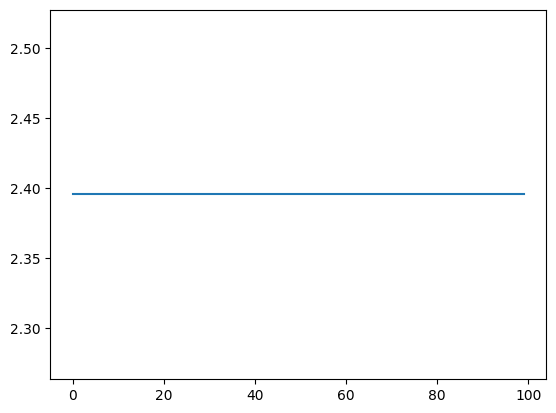

In [ ]:
best_model = train(model=model,metric=nn.CrossEntropyLoss(),data=training_set.data,labels=training_set.targets,iterations=100,n_particles=10,alpha=0.5,beta=0.5)

In [ ]:
validation_set.data = validation_set.data.type(torch.float32)

In [ ]:
from sklearn import metrics

y_pred = best_model(validation_set.data)

In [ ]:
tmp = [torch.argmax(y_pred[i]) for i in range(len(y_pred))]

In [ ]:
metrics.accuracy_score(validation_set.targets.detach().numpy(),tmp)

0.1102

In [ ]:
nn.CrossEntropyLoss()(y_pred,validation_set.targets).item()

2.4397425651550293